In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy.stats as stats
import random

import utilities as ut
import modularised_utils as mut
import evaluation_utils as evut

sns.set_theme(style="whitegrid")
seed = 42
np.random.seed(seed)

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [2]:
experiment = 'slc'
path = f"data/{experiment}"
saved_folds = joblib.load(f"data/{experiment}/cv_folds.pkl")

In [3]:
# Load the dictionaries containing the results for each optimization method
diroca_results_empirical    = joblib.load(f"{path}/diroca_cv_results_empirical.pkl")
gradca_results_empirical    = joblib.load(f"{path}/gradca_cv_results_empirical.pkl")
baryca_results_empirical    = joblib.load(f"{path}/baryca_cv_results_empirical.pkl")
abslingam_results_empirical = joblib.load(f"{path}/abslingam_cv_results_empirical.pkl")

print("Successfully loaded results for all optimization methods.")
print(f"  - DIROCA results keys: {list(diroca_results_empirical.keys())}")
print(f"  - GradCA results keys: {list(gradca_results_empirical.keys())}")
print(f"  - BARYCA results keys: {list(baryca_results_empirical.keys())}")
print(f"  - Abs-LiNGAM results keys: {list(abslingam_results_empirical.keys())}")

results_to_evaluate = {
                            "DIROCA": diroca_results_empirical,
                            "GradCA": gradca_results_empirical,
                            "BARYCA": baryca_results_empirical,
                            "Abs-LiNGAM": abslingam_results_empirical 
                        }

Successfully loaded results for all optimization methods.
  - DIROCA results keys: ['fold_0', 'fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5', 'fold_6', 'fold_7', 'fold_8', 'fold_9']
  - GradCA results keys: ['fold_0', 'fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5', 'fold_6', 'fold_7', 'fold_8', 'fold_9']
  - BARYCA results keys: ['fold_0', 'fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5', 'fold_6', 'fold_7', 'fold_8', 'fold_9']
  - Abs-LiNGAM results keys: ['fold_0', 'fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5', 'fold_6', 'fold_7', 'fold_8', 'fold_9']


In [4]:
# Load the original data dictionary
all_data      = ut.load_all_data(experiment)

Dll_samples   = all_data['LLmodel']['data']
Dhl_samples   = all_data['HLmodel']['data']
I_ll_relevant = all_data['LLmodel']['intervention_set']
omega         = all_data['abstraction_data']['omega']
ll_var_names  = list(all_data['LLmodel']['graph'].nodes())
hl_var_names  = list(all_data['HLmodel']['graph'].nodes())

Data loaded for 'slc'.


In [5]:
def calculate_empirical_error(T_matrix, Dll_test, Dhl_test, metric='fro'):
    """
    Calculates the abstraction error directly on the endogenous data samples
    by computing a matrix norm between the transformed LL data and the HL data.
    
    Args:
        T_matrix (np.ndarray): The learned abstraction matrix.
        Dll_test (np.ndarray): The low-level endogenous test samples.
        Dhl_test (np.ndarray): The high-level endogenous test samples.
        metric (str): The distance metric to use (e.g., 'fro', 'l1', 'nuclear').
        
    Returns:
        float: The calculated empirical distance.
    """
    if Dll_test.shape[0] == 0 or Dhl_test.shape[0] == 0:
        return np.nan # Cannot compute error on empty data

    try:
        # 1. Transform the low-level data samples using the learned T matrix
        Dhl_predicted = Dll_test @ T_matrix.T
        
        # 2. Compute the direct distance between the predicted and actual data matrices.
        #    NOTE: We transpose the matrices here to match the expected input
        #          of your original compute_empirical_distance function.
        error = evut.compute_empirical_distance(Dhl_predicted.T, Dhl_test.T, metric)
        
    except Exception as e:
        print(f"  - Warning: Could not compute empirical distance. Error: {e}. Returning NaN.")
        return np.nan

    return error

In [6]:
def apply_shift(clean_data, shift_config, all_var_names, model_level, seed=None):
    """
    Applies a specified contamination, using a dedicated random generator
    for reproducibility.
    """
    # Create a local random number generator from the seed
    rng = np.random.default_rng(seed)
    
    shift_type = shift_config.get('type')
    dist_type = shift_config.get('distribution', 'gaussian')
    n_samples, n_dims = clean_data.shape

    level_key = 'll_params' if model_level == 'L' else 'hl_params'
    params = shift_config.get(level_key, {})
    
    noise_matrix = np.zeros_like(clean_data)
    if dist_type == 'gaussian':
        mu = np.array(params.get('mu', np.zeros(n_dims)))
        sigma_def = params.get('sigma', np.eye(n_dims))
        sigma = np.diag(np.array(sigma_def)) if np.array(sigma_def).ndim == 1 else np.array(sigma_def)
        # Use the local generator
        noise_matrix = rng.multivariate_normal(mean=mu, cov=sigma, size=n_samples)

    elif dist_type == 'student-t':
        df = params.get('df', 3)
        loc = np.array(params.get('loc', np.zeros(n_dims)))
        shape_def = params.get('shape', np.eye(n_dims))
        shape = np.diag(np.array(shape_def)) if np.array(shape_def).ndim == 1 else np.array(shape_def)
        # scipy.stats can also use a specific random state
        noise_matrix = stats.multivariate_t.rvs(loc=loc, shape=shape, df=df, size=n_samples, random_state=rng)

    elif dist_type == 'exponential':
        scale = params.get('scale', 1.0)
        # Use the local generator
        noise_matrix = rng.exponential(scale=scale, size=(n_samples, n_dims))
    
    final_noise = np.zeros_like(clean_data)
    vars_to_affect = params.get('apply_to_vars')

    if vars_to_affect is None:
        final_noise = noise_matrix
    else:
        indices_to_affect = [all_var_names.index(var) for var in vars_to_affect if var in all_var_names]
        final_noise[:, indices_to_affect] = noise_matrix[:, indices_to_affect]

    return clean_data + final_noise if shift_type == 'additive' else clean_data * final_noise

In [7]:
def apply_huber_contamination(clean_data, alpha, shift_config, all_var_names, model_level, seed=None):
    """
    Contaminates a dataset using the Huber model with a specific seed for reproducibility.
    """
    if not (0 <= alpha <= 1):
        raise ValueError("Alpha must be between 0 and 1.")
    if alpha == 0:
        return clean_data
    
    # Pass the seed down to the noise generation function
    noisy_data = apply_shift(clean_data, shift_config, all_var_names, model_level, seed=seed)
    
    if alpha == 1:
        return noisy_data
        
    n_samples = clean_data.shape[0]
    n_to_contaminate = int(alpha * n_samples)
    
    # Use a local generator to select which rows to replace
    rng = np.random.default_rng(seed)
    indices_to_replace = rng.choice(n_samples, n_to_contaminate, replace=False)
    
    contaminated_data = clean_data.copy()
    contaminated_data[indices_to_replace] = noisy_data[indices_to_replace]
    
    return contaminated_data

In [8]:
def plot_robustness_curves(results_df):
    """
    Plots the abstraction error as a function of contamination strength for each method.
    """
    plt.figure(figsize=(12, 8))
    
    sns.lineplot(
        data=results_df, 
        x='noise_scale', 
        y='error', 
        hue='method', 
        marker='o',
        errorbar=('ci', 95) # Show 95% confidence interval
    )
    
    plt.title('Robustness Curve: Abstraction Error vs. Noise Level', fontsize=16)
    plt.xlabel('Contamination Strength (Noise Scale)', fontsize=12)
    plt.ylabel('Average Abstraction Error (Wasserstein Distance)', fontsize=12)
    plt.legend(title='Method')
    plt.grid(True, which='both', linestyle='--')
    plt.show()


def perform_statistical_tests(results_df, method1, method2, test_type='paired-t'):
    """
    Compares two methods at each noise level using a statistical test.
    """
    print(f"\n--- Statistical Significance Test: {method1} vs. {method2} ({test_type}) ---")
    
    df_sorted = results_df.sort_values('fold')
    noise_levels = sorted(df_sorted['noise_scale'].unique())
    
    for level in noise_levels:
        df_level = df_sorted[df_sorted['noise_scale'] == level]
        
        errors1 = df_level[df_level['method'] == method1]['error'].dropna()
        errors2 = df_level[df_level['method'] == method2]['error'].dropna()

        if len(errors1) != len(errors2) or len(errors1) < 2:
            print(f"  - At Noise Level {level:.2f}: Not enough data to perform test.")
            continue
            
        # Perform statistical test
        if test_type == 'paired-t':
            stat, p_value = stats.ttest_rel(errors1, errors2)
        elif test_type == 'wilcoxon':
            # Wilcoxon is for paired, non-parametric data
            stat, p_value = stats.wilcoxon(errors1, errors2)
        else: # Independent t-test
            stat, p_value = stats.ttest_ind(errors1, errors2)

        # Report the result
        print(f"  - At Noise Level {level:.2f}: p-value = {p_value:.4f}", end="")
        if p_value < 0.05:
            winner = method1 if np.mean(errors1) < np.mean(errors2) else method2
            print(f" (Significant difference, {winner} is better)")
        else:
            print(" (No significant difference)")

# End-to-End Huber Evaluation

In [9]:
# Define the fraction of data to contaminate (0=0-shift, 1=rho-shift)
alpha_values = np.linspace(0, 1.0, 10)

# Define the contamination strength for the outliers
noise_levels = np.linspace(0, 10.0, 10) 

# Define how many random noise draws to average over for each setting
num_trials = 10 # A higher number gives a more stable estimate

# Define base covariance matrices
base_sigma_L = np.eye(len(all_data['LLmodel']['graph'].nodes()))
base_sigma_H = np.eye(len(all_data['HLmodel']['graph'].nodes()))

# ======================================================================
# 2. THE DATA COLLECTION LOOP
# ======================================================================
print("🚀 Starting full robustness evaluation...")
evaluation_records = []

for alpha in tqdm(alpha_values, desc="Alpha Levels"):
    for scale in noise_levels:
        for trial in range(num_trials):
            for i, fold_info in enumerate(saved_folds):
                for method_name, results_dict in results_to_evaluate.items():
                    fold_results = results_dict[f'fold_{i}']
                    for run_key, run_data in fold_results.items():
                        T_learned = run_data['T_matrix']
                        test_indices = run_data['test_indices']
                        
                        errors_per_intervention = []
                        for iota in I_ll_relevant:
                            Dll_test_clean = Dll_samples[iota][test_indices]
                            Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
                            
                            shift_config = {
                                'type': 'additive', 'distribution': 'gaussian',
                                'll_params': {'mu': np.zeros(base_sigma_L.shape[0]), 'sigma': base_sigma_L * (scale**2)},
                                'hl_params': {'mu': np.zeros(base_sigma_H.shape[0]), 'sigma': base_sigma_H * (scale**2)}
                            }
                            
                            Dll_test_contaminated = apply_huber_contamination(Dll_test_clean, alpha, shift_config, ll_var_names, 'L')
                            Dhl_test_contaminated = apply_huber_contamination(Dhl_test_clean, alpha, shift_config, hl_var_names, 'H')
                            
                            error = calculate_empirical_error(T_learned, Dll_test_contaminated, Dhl_test_contaminated)
                            if not np.isnan(error):
                                errors_per_intervention.append(error)
                        
                        avg_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
                        
                        record = {
                            'method': method_name, 'run_id': run_key, 'alpha': alpha,
                            'noise_scale': scale, 'trial': trial, 'fold': i, 'error': avg_error
                        }
                        evaluation_records.append(record)

final_results_df = pd.DataFrame(evaluation_records)
print("\n--- Full Evaluation Complete ---")
print("All detailed results are stored in 'final_results_df'.")

🚀 Starting full robustness evaluation...


Alpha Levels:   0%|          | 0/10 [00:00<?, ?it/s]

Alpha Levels: 100%|██████████| 10/10 [04:22<00:00, 26.20s/it]


--- Full Evaluation Complete ---
All detailed results are stored in 'final_results_df'.


In [10]:
# 1. First, calculate the summary statistics DataFrame using groupby and agg
print("--- Final Summary (Mean Error ± Std Dev across all folds) ---")
# Corrected line
summary_stats = final_results_df.groupby(['method', 'run_id'])['error'].agg(['mean', 'std']).sort_values('mean')
# Display the raw summary DataFrame
display(summary_stats)


# 2. Now, print the results in your custom table format
print("\n" + "="*60)
print(f"{'Method/Run':<35} | {'Mean Error ± Std Dev'}")
print("="*60)

for index, row in summary_stats.iterrows():
    # Unpack the multi-index
    method, run_id = index
    
    mean_val = row['mean']
    std_val = row['std']
    
    # Create a clean name for display in the table
    display_name = f"{method} ({run_id})"
    
    print(f"{display_name:<35} | {mean_val:>7.4f} ± {std_val:.4f}")

print("="*60)

--- Final Summary (Mean Error ± Std Dev across all folds) ---


mean         std
method     run_id                                       
DIROCA     eps_4.0_delta_4.0      189.746881  133.315179
           eps_2.0_delta_2.0      189.761612  133.379182
           eps_8.0_delta_8.0      189.766921  133.323622
           eps_1.0_delta_1.0      203.073987  146.037972
GradCA     gradca_run             203.630175  148.893558
BARYCA     baryca_run             291.456558  215.826821
Abs-LiNGAM Noisy                  308.180533  224.001587
DIROCA     eps_0.103_delta_0.033  319.700581  235.852234
Abs-LiNGAM Perfect                325.455708  238.712132


Method/Run                          | Mean Error ± Std Dev
DIROCA (eps_4.0_delta_4.0)          | 189.7469 ± 133.3152
DIROCA (eps_2.0_delta_2.0)          | 189.7616 ± 133.3792
DIROCA (eps_8.0_delta_8.0)          | 189.7669 ± 133.3236
DIROCA (eps_1.0_delta_1.0)          | 203.0740 ± 146.0380
GradCA (gradca_run)                 | 203.6302 ± 148.8936
BARYCA (baryca_run)                 | 291.4566 ± 215.8268
Abs-LiNGAM (Noisy)                  | 308.1805 ± 224.0016
DIROCA (eps_0.103_delta_0.033)      | 319.7006 ± 235.8522
Abs-LiNGAM (Perfect)                | 325.4557 ± 238.7121


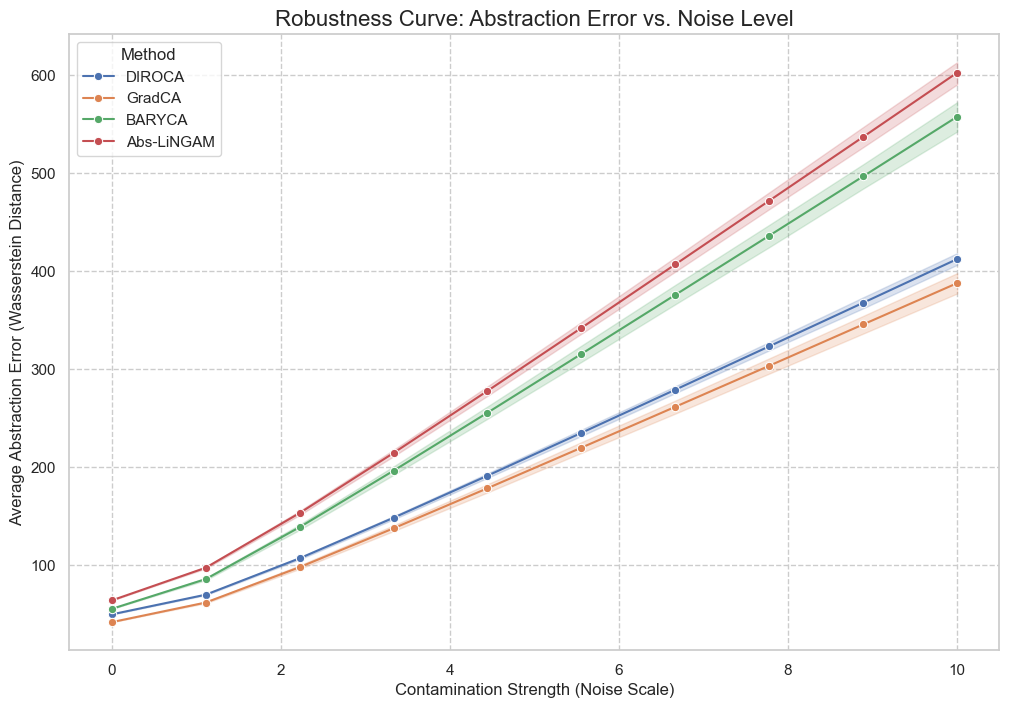

In [11]:
# First, generate the main plot
plot_robustness_curves(final_results_df)

# Then, run statistical tests to compare pairs of methods
# A paired t-test is appropriate here because the methods are tested on the same k-fold splits.
# perform_statistical_tests(final_results_df, 'DIROCA', 'GradCA', test_type='paired-t')
# perform_statistical_tests(final_results_df, 'DIROCA', 'BARYCA', test_type='paired-t')

In [15]:
# Set this to one of: 'robustness_curve', 'outlier_fraction_curve', or 'point_comparison'
analysis_mode = 'point_comparison'

# Used if analysis_mode = 'robustness_curve'
alpha_to_plot = 0.0

# Used if analysis_mode = 'outlier_fraction_curve'
noise_level_to_plot = 0.0 

# Used if analysis_mode = 'point_comparison'
alpha_point = 1.0
noise_level_point = 10.0

if analysis_mode == 'robustness_curve':
    print(f"--- Generating Robustness Curve for Alpha = {alpha_to_plot} ---")
    df_subset = final_results_df[np.isclose(final_results_df['alpha'], alpha_to_plot)]
    
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=df_subset, x='noise_scale', y='error', hue='method', style='run_id', marker='o', errorbar=('ci', 95))
    plt.title(f'Robustness to Noise Intensity (at Alpha = {alpha_to_plot})', fontsize=18)
    plt.xlabel('Contamination Strength (Noise Scale)', fontsize=14)
    plt.ylabel('Average Abstraction Error', fontsize=14)
    plt.legend(title='Method')
    plt.grid(True, which='both', linestyle='--')
    plt.show()

elif analysis_mode == 'outlier_fraction_curve':
    print(f"--- Generating Outlier Fraction Curve for Noise Scale = {noise_level_to_plot} ---")
    df_subset = final_results_df[np.isclose(final_results_df['noise_scale'], noise_level_to_plot)]
    
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=df_subset, x='alpha', y='error', hue='method', style='run_id', marker='o', errorbar=('ci', 95))
    plt.title(f'Robustness to Outlier Fraction (at Noise Scale ≈ {noise_level_to_plot})', fontsize=18)
    plt.xlabel('Contamination Fraction (alpha)', fontsize=14)
    plt.ylabel('Average Abstraction Error', fontsize=14)
    plt.legend(title='Method')
    plt.grid(True, which='both', linestyle='--')
    plt.show()

elif analysis_mode == 'point_comparison':
    print(f"--- Generating Point Comparison for Alpha={alpha_point}, Noise Scale={noise_level_point} ---")
    
    df_subset = final_results_df[
        (np.isclose(final_results_df['alpha'], alpha_point)) &
        (np.isclose(final_results_df['noise_scale'], noise_level_point))
    ]
    
    summary_table = df_subset.groupby(['method', 'run_id'])['error'].agg(['mean', 'std', 'count'])
    
    # Calculate the Standard Error of the Mean (SEM)
    summary_table['sem'] = summary_table['std'] / np.sqrt(summary_table['count'])
    
    print("\nPerformance under this specific condition (with SEM):")
    display(summary_table)

    # Mean ± SEM
    print("\n" + "="*65)
    print(f"{'Method/Run':<35} | {'Mean Error ± Standard Error of Mean (SEM)'}")
    print("="*65)

    for index, row in summary_table.iterrows():
        display_name = f"{row.name[0]} ({row.name[1]})"
        mean_val = row['mean']
        sem_val = row['sem']
        
        print(f"{display_name:<35} | {mean_val:>7.4f} ± {sem_val:.4f}")
    print("="*65)

# Statistical tests
# perform_statistical_tests(df_subset, 'DIROCA', 'GradCA')
# perform_statistical_tests(df_subset, 'DIROCA', 'BARYCA')

--- Generating Point Comparison for Alpha=1.0, Noise Scale=10.0 ---

Performance under this specific condition (with SEM):


mean       std  count       sem
method     run_id                                                      
Abs-LiNGAM Noisy                  898.922124  7.106219    100  0.710622
           Perfect                950.741187  7.101134    100  0.710113
BARYCA     baryca_run             856.894591  7.165679    100  0.716568
DIROCA     eps_0.103_delta_0.033  937.701475  7.031224    100  0.703122
           eps_1.0_delta_1.0      588.070401  4.064023    100  0.406402
           eps_2.0_delta_2.0      544.160683  3.998766    100  0.399877
           eps_4.0_delta_4.0      543.116645  3.546877    100  0.354688
           eps_8.0_delta_8.0      542.649720  3.530387    100  0.353039
GradCA     gradca_run             594.997199  4.009906    100  0.400991


Method/Run                          | Mean Error ± Standard Error of Mean (SEM)
Abs-LiNGAM (Noisy)                  | 898.9221 ± 0.7106
Abs-LiNGAM (Perfect)                | 950.7412 ± 0.7101
BARYCA (baryca_run)                 | 856.8946 ± 0.7166
DIROCA (eps_0.103_delta_0.033)      | 937.7015 ± 0.7031
DIROCA (eps_1.0_delta_1.0)          | 588.0704 ± 0.4064
DIROCA (eps_2.0_delta_2.0)          | 544.1607 ± 0.3999
DIROCA (eps_4.0_delta_4.0)          | 543.1166 ± 0.3547
DIROCA (eps_8.0_delta_8.0)          | 542.6497 ± 0.3530
GradCA (gradca_run)                 | 594.9972 ± 0.4010


## F-contamination

In [16]:
def contaminate_data(data, strength, contamination_type, num_segments=10, seed=None):
    """
    Applies a specified contamination to data samples to simulate model misspecification.

    Args:
        data (np.ndarray): The original data samples.
        strength (float): The magnitude of the contamination.
        contamination_type (str): 'piecewise', 'multiplicative', or 'nonlinear'.
        num_segments (int): Number of segments for the 'piecewise' type.
        seed (int, optional): Random seed for reproducibility.
        
    Returns:
        np.ndarray: The contaminated data.
    """
    rng = np.random.default_rng(seed)
    data_cont = data.copy()
    
    if contamination_type == "multiplicative":
        # Apply element-wise multiplicative noise
        noise = rng.uniform(low=1.0 - strength, high=1.0 + strength, size=data.shape)
        data_cont *= noise
  
    elif contamination_type == "nonlinear":
        # Apply a sine-based non-linear distortion
        data_cont += strength * np.sin(data_cont)
  
    elif contamination_type == "piecewise":
        # Apply piecewise contamination to each column (variable)
        for col_idx in range(data.shape[1]):
            column = data_cont[:, col_idx]
            breakpoints = np.quantile(column, q=np.linspace(0, 1, num_segments + 1))
            breakpoints[-1] += 1e-6 # Ensure the last element is included
            
            for i in range(num_segments):
                factor = 1.0 + rng.uniform(low=-strength, high=strength)
                mask = (column >= breakpoints[i]) & (column < breakpoints[i+1])
                data_cont[mask, col_idx] *= factor
  
    else:
        raise ValueError(f"Unknown contamination type: {contamination_type}")
  
    return data_cont

🚀 Starting F-misspecification evaluation for type: 'multiplicative'...


Contamination Strength: 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


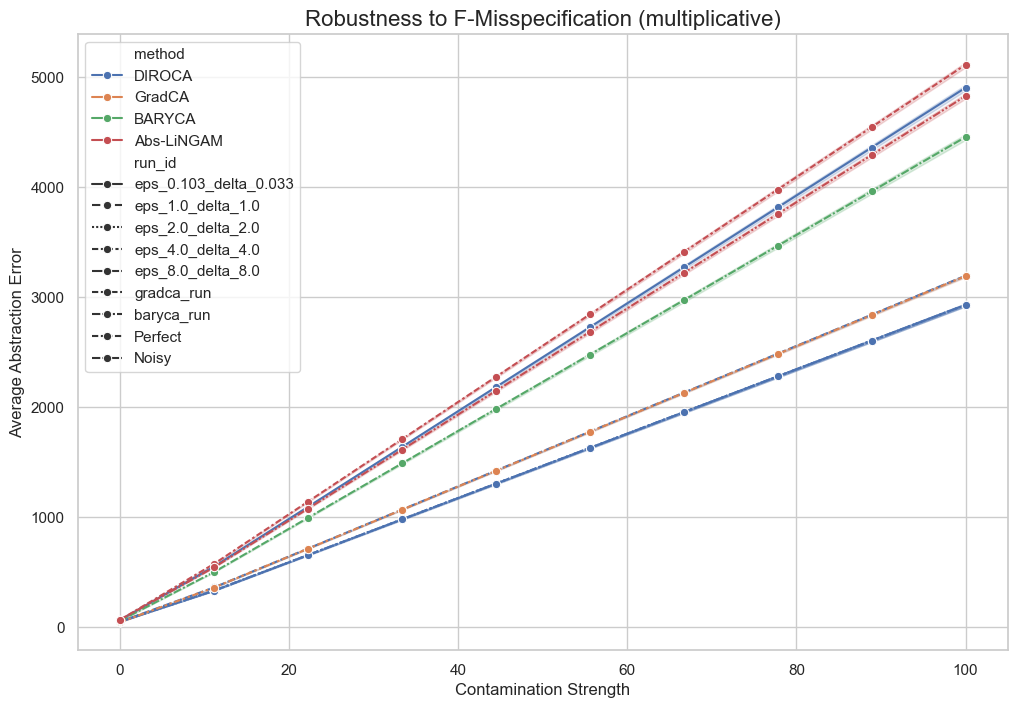

In [17]:
# --- F-Misspecification Evaluation Cell ---

# ======================================================================
# 1. CONTROL PANEL
# ======================================================================

# Choose which type of non-linearity to test
contamination_type_to_run = 'multiplicative' # Options: 'piecewise', 'multiplicative', 'nonlinear'

# Define the range of contamination strengths
contamination_strengths = np.linspace(0, 100, 10) 

# Define how many random contaminations to average over
num_trials = 2

# ======================================================================
# 2. EVALUATION LOOP
# ======================================================================
print(f"🚀 Starting F-misspecification evaluation for type: '{contamination_type_to_run}'...")
f_spec_records = []

for strength in tqdm(contamination_strengths, desc="Contamination Strength"):
    for trial in range(num_trials):
        for i, fold_info in enumerate(saved_folds):
            for method_name, results_dict in results_to_evaluate.items():
                fold_results = results_dict[f'fold_{i}']
                for run_key, run_data in fold_results.items():
                    T_learned, test_indices = run_data['T_matrix'], run_data['test_indices']
                    
                    errors_per_intervention = []
                    for iota in I_ll_relevant:
                        Dll_test_clean = Dll_samples[iota][test_indices]
                        Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
                        
                        # Apply F-contamination to the clean data
                        Dll_test_cont = contaminate_data(Dll_test_clean, strength, contamination_type_to_run, seed=trial)
                        Dhl_test_cont = contaminate_data(Dhl_test_clean, strength, contamination_type_to_run, seed=trial)
                        
                        error = calculate_empirical_error(T_learned, Dll_test_cont, Dhl_test_cont)
                        if not np.isnan(error): errors_per_intervention.append(error)
                    
                    avg_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
                    
                    f_spec_records.append({
                        'method': method_name, 'run_id': run_key, 
                        'contamination_strength': strength, 'error': avg_error
                    })

# ======================================================================
# 3. ANALYSIS AND PLOTTING
# ======================================================================
f_spec_df = pd.DataFrame(f_spec_records)
plt.figure(figsize=(12, 8))
sns.lineplot(data=f_spec_df, x='contamination_strength', y='error', hue='method', style='run_id', marker='o', errorbar=('ci', 95))
plt.title(f'Robustness to F-Misspecification ({contamination_type_to_run})', fontsize=16)
plt.xlabel('Contamination Strength', fontsize=12)
plt.ylabel('Average Abstraction Error', fontsize=12)
plt.show()

## ω contamination

In [18]:
def contaminate_omega_map(original_omega, num_misalignments):
    """Randomly re-wires a subset of entries in the omega map."""
    
    # Get a list of interventions that can be changed (i.e., are not None)
    valid_keys = [k for k in original_omega.keys() if k is not None]
    
    if not valid_keys: return original_omega.copy()
        
    contaminated_omega = original_omega.copy()
    num_to_corrupt = min(num_misalignments, len(valid_keys))
    
    # Randomly select interventions to misalign
    keys_to_corrupt = random.sample(valid_keys, k=num_to_corrupt)
    
    # Get the list of all possible high-level targets
    all_hl_targets = list(set(val for val in original_omega.values() if val is not None))
    
    for key in keys_to_corrupt:
        original_target = contaminated_omega[key]
        # Find potential new targets that are different from the original
        available_new_targets = [t for t in all_hl_targets if t != original_target]
        
        if available_new_targets:
            # Reassign to a random, incorrect target
            contaminated_omega[key] = random.choice(available_new_targets)
            
    return contaminated_omega


🚀 Starting Omega-misspecification evaluation...


Misalignment Level: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


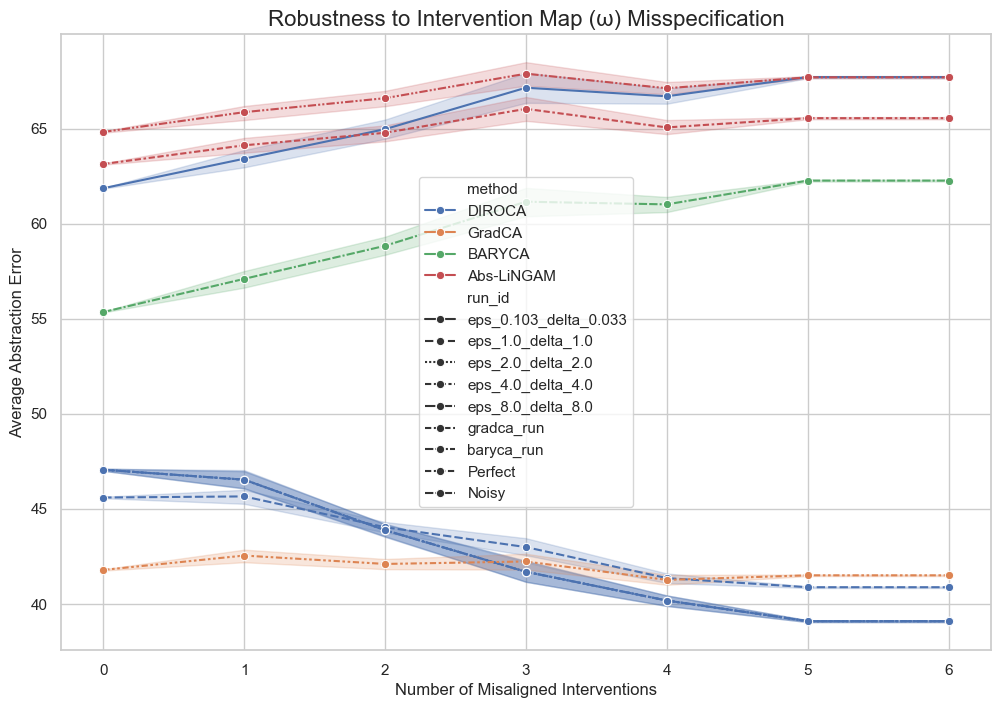

In [19]:
max_misalignments   = len(I_ll_relevant)
misalignment_levels = np.linspace(0, max_misalignments, 10, dtype=int)

num_trials           = 10
# ======================================================================
# 2. EVALUATION LOOP
# ======================================================================
print("\n🚀 Starting Omega-misspecification evaluation...")
omega_spec_records = []

for num_misalignments in tqdm(misalignment_levels, desc="Misalignment Level"):
    for trial in range(num_trials):
        # Create a new scrambled omega map for each trial
        omega_cont = contaminate_omega_map(omega, num_misalignments)
        
        for i, fold_info in enumerate(saved_folds):
            for method_name, results_dict in results_to_evaluate.items():
                fold_results = results_dict[f'fold_{i}']
                for run_key, run_data in fold_results.items():
                    T_learned, test_indices = run_data['T_matrix'], run_data['test_indices']
                    
                    errors_per_intervention = []
                    for iota in I_ll_relevant:
                        Dll_test = Dll_samples[iota][test_indices]
                        # Fetch HL data using the CONTAMINATED map
                        Dhl_test = Dhl_samples[omega_cont[iota]][test_indices]
                        
                        error = calculate_empirical_error(T_learned, Dll_test, Dhl_test)
                        if not np.isnan(error): errors_per_intervention.append(error)
                    
                    avg_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
                    omega_spec_records.append({
                        'method': method_name, 'run_id': run_key,
                        'misalignments': num_misalignments, 'error': avg_error
                    })

# ======================================================================
# 3. ANALYSIS AND PLOTTING
# ======================================================================
omega_spec_df = pd.DataFrame(omega_spec_records)
plt.figure(figsize=(12, 8))
sns.lineplot(data=omega_spec_df, x='misalignments', y='error', hue='method', style='run_id', marker='o', errorbar=('ci', 95))
plt.title('Robustness to Intervention Map (ω) Misspecification', fontsize=16)
plt.xlabel('Number of Misaligned Interventions', fontsize=12)
plt.ylabel('Average Abstraction Error', fontsize=12)
plt.show()